In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/MyDrive/Text Classification/"

/content/gdrive/MyDrive/Text Classification


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba
import re

In [4]:
dataset = pd.read_csv('20200913-Top10')

In [5]:
dataset.head()

,新闻标题,一级类目
0,南宁市交通运输局到广州市开展枢纽经济发展调研,时政
1,加州宣布独立，纽约州宣布取消总统初选，现在的美国到底有多乱？,时政
2,曾是凯迪拉克的“专属标签”，远光狗的克星，为什么却火不起来呢？,汽车
3,赵丽颖冯绍峰终于秀恩爱！穿镂空白裤秀小蛮腰，冯绍峰清爽帅气,娱乐
4,贵州一男子厕所杀鱼，不料鱼钻进便池孔！他伸手去捞，被“咬住”了……,社会


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611403 entries, 0 to 611402
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   新闻标题    611403 non-null  object
 1   一级类目    611403 non-null  object
dtypes: object(2)
memory usage: 9.3+ MB


In [7]:
dataset["一级类目"].value_counts()

社会    128678
娱乐     98215
时政     95548
汽车     52557
健康     50048
教育     43091
财经     42451
科技     38208
体育     33684
文化     28923
Name: 一级类目, dtype: int64

In [8]:
def clean_data(sentence):
    clean_punc_text = re.sub(r'[^\w\s]', '', sentence).replace(" ","").strip()
    clean_punc_num_text = re.sub(r'[0-9]+', '', clean_punc_text)
    clean_punc_num_eng_text = re.sub(r'[a-zA-Z]+', '', clean_punc_num_text) 
    return clean_punc_num_eng_text

dataset["新闻标题"] = dataset["新闻标题"].apply(clean_data)
dataset.head()

,新闻标题,一级类目
0,南宁市交通运输局到广州市开展枢纽经济发展调研,时政
1,加州宣布独立纽约州宣布取消总统初选现在的美国到底有多乱,时政
2,曾是凯迪拉克的专属标签远光狗的克星为什么却火不起来呢,汽车
3,赵丽颖冯绍峰终于秀恩爱穿镂空白裤秀小蛮腰冯绍峰清爽帅气,娱乐
4,贵州一男子厕所杀鱼不料鱼钻进便池孔他伸手去捞被咬住了,社会


In [9]:
def jieba_tokenize(sentence):
    return " ".join([word for word in jieba.cut(sentence)])

dataset["新闻标题"] = dataset["新闻标题"].apply(jieba_tokenize)
dataset.head()

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.760 seconds.
Prefix dict has been built successfully.


,新闻标题,一级类目
0,南宁市 交通运输 局到 广州市 开展 枢纽 经济 发展 调研,时政
1,加州 宣布独立 纽约州 宣布 取消 总统 初选 现在 的 美国 到底 有多乱,时政
2,曾 是 凯迪拉克 的 专属 标签 远光 狗 的 克星 为什么 却 火 不 起来 呢,汽车
3,赵丽颖 冯绍峰 终于 秀 恩爱 穿 镂空 白裤 秀小蛮 腰 冯绍峰 清爽 帅气,娱乐
4,贵州 一 男子 厕所 杀鱼 不料 鱼 钻进 便池 孔 他 伸手 去 捞 被 咬住 了,社会


In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

data, label = dataset["新闻标题"].values, dataset["一级类目"].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
data = pad_sequences(sequences)
label = to_categorical(LabelEncoder().fit_transform(label))
print('Shape of data:', data.shape)
print('Shape of label:', label.shape)

Shape of data: (611403, 44)
Shape of label: (611403, 10)


In [11]:
from sklearn.model_selection import train_test_split

train_X, valid_test_X, train_y, valid_test_y = train_test_split(data, label, test_size=0.1, stratify=label, random_state=42)
print('shape of train_X:', train_X.shape)
print('shape of valid_test_X:', valid_test_X.shape)
print('shape of train_y:', train_y.shape)
print('shape of valid_test_y:', valid_test_y.shape)

shape of train_X: (550262, 44)
shape of valid_test_X: (61141, 44)
shape of train_y: (550262, 10)
shape of valid_test_y: (61141, 10)


In [12]:
valid_X, test_X, valid_y, test_y = train_test_split(valid_test_X, valid_test_y, test_size=0.5, stratify=valid_test_y, random_state=42)
print('shape of valid_X:', valid_X.shape)
print('shape of test_X:', test_X.shape)
print('shape of valid_y:', valid_y.shape)
print('shape of test_y:', test_y.shape)

shape of valid_X: (30570, 44)
shape of test_X: (30571, 44)
shape of valid_y: (30570, 10)
shape of test_y: (30571, 10)


In [13]:
embeddings_table = {}
with open('100000-small.txt','r') as file:
  for row_index, line in enumerate(file):
    if row_index == 0:
      continue
    row_data = line.split()
    word = row_data[0]
    vector = np.array(row_data[1:], dtype='float32')
    embeddings_table[word] = vector

In [14]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBED_SIZE = 200

word_index = tokenizer.word_index
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_SIZE))
for word, index in word_index.items():
  embedding_vector = embeddings_table.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [15]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):

    def __init__(self, return_sequences=False):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()
        
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")
        super(Attention, self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)

    def get_config(self):
      base_config = super(Attention, self).get_config().copy()
      base_config.update({
            'return_sequences': self.return_sequences,
            })
      return base_config

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Embedding, GRU, Bidirectional

OUTPUT_DIM = 64
MAX_LENGTH = 44

input = Input(shape=[MAX_LENGTH])
mask = Lambda(lambda inputs: K.not_equal(inputs, 0))(input)
embed_layer = Embedding(VOCAB_SIZE, EMBED_SIZE, weights=[embedding_matrix], mask_zero=True, input_length=MAX_LENGTH)(input)
att_embed_layer = Attention(return_sequences=True)(embed_layer)
repr_layer = Bidirectional(GRU(OUTPUT_DIM, return_sequences=True))(att_embed_layer, mask=mask)
att_repr_layer = Attention(return_sequences=False)(repr_layer)
output = Dense(10, activation="softmax")(att_repr_layer)
model = Model(inputs=[input], outputs=[output])

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 44)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 44, 200)      51291200    input_3[0][0]                    
__________________________________________________________________________________________________
attention_3 (Attention)         (None, 44, 200)      244         embedding_2[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 44)           0           input_3[0][0]                    
____________________________________________________________________________________________

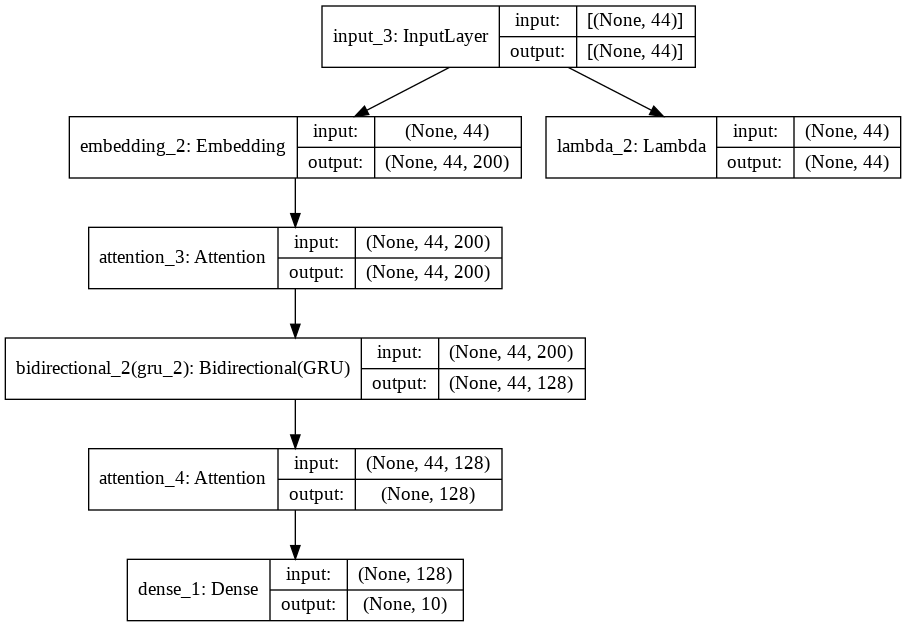

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, "att_rnn_model.png", show_shapes=True)

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_X, train_y, validation_data=(valid_X, valid_y), epochs=1, batch_size=256, verbose=1)

2150/2150 [==============================] - 1344s 623ms/step - loss: 0.3923 - accuracy: 0.8698 - val_loss: 0.4692 - val_accuracy: 0.8432


In [27]:
loss, accuracy = model.evaluate(test_X, test_y)
print("loss of the test data: {:.3f}".format(loss))
print("accuracy of the test data: {:.3f}".format(accuracy))

956/956 [==============================] - 24s 25ms/step - loss: 0.4693 - accuracy: 0.8428
loss of the test data: 0.469
accuracy of the test data: 0.843


In [28]:
model.save("att_birnn_model.h5")